# Azure Data University: mlos_bench MySQL data analysis

In this notebook, we will look at the mlos_bench data we've collected while optimizing the MySQL Server configuration for Azure.

### 1. Import packages

First, import some standard Python packages for data manipulation and plotting.

We'll also use the `mlos_bench` Storage API to retrieve the data from our experiments.

In [1]:
import pandas
from matplotlib import pyplot as plt
import seaborn as sns

from mlos_bench.storage import from_config

In [2]:
# Cosmetic: Suppress some annoying warnings from third-party data visualization packages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### 2. Connect to the DB using existing mlos_bench configs

We reuse the existing `mlos_bench` framework configuration file that contains the DB connection parameters. This way we make sure to connect to the same database that our framework uses to store the experimental data.

In [3]:
storage = from_config(config_file="storage/sqlite.jsonc")

### 3. List all experiments

User-facing Storage API basically has a single property, `.experiments`, that returns a Python `dict` of (Experiment ID, Experiment Data) key/value pairs.

In [4]:
storage.experiments

{'mysql-innodb-bseries-v346-vmcontrol': Experiment :: mysql-innodb-bseries-v346-vmcontrol: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-buf': Experiment :: mysql-innodb-buf: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-explore-D2S': Experiment :: mysql-innodb-explore-D2S: 'Azure MySQL+Sysbench Root',
 'sqlite-sync-journal-pagesize-caching-experiment': Experiment :: sqlite-sync-journal-pagesize-caching-experiment: 'sqlite-local-benchbase'}

We can see our SQLite optimization experiments and some past data from MySQL Server optimization.

### 4. Get all data for one experiment

Knowing the Experiment ID, we can access all data related to this experiment.

In [5]:
exp = storage.experiments["mysql-innodb-explore-D2S"]
exp

Experiment :: mysql-innodb-explore-D2S: 'Azure MySQL+Sysbench Root'

Main method that combines the information about each trial along with the trial configuration parameters and its results, is the property `.results`. It conveniently returns all data about the experiment is a single Pandas DataFrame.

In [6]:
df = exp.results
df.head()

,trial_id,ts_start,ts_end,config_id,status,config.innodb_buffer_pool_dump_pct,config.innodb_buffer_pool_instances,config.innodb_flush_method,config.innodb_log_buffer_size,config.innodb_old_blocks_pct,...,result.latency_pct,result.other,result.percentile,result.reads,result.reconnects,result.score,result.threads,result.time,result.total,result.writes
0,1,2023-07-20 20:18:30,2023-07-20 20:51:50,382,SUCCEEDED,100,8,fsync,16,37,...,69.289067,39.732553,95.0,1424.230357,0.0,69.289067,0.0,600.010582,1998.272415,534.309505
1,2,2023-07-20 20:51:51,2023-07-20 21:06:20,383,SUCCEEDED,78,2,O_DSYNC,461,23,...,99.327030,31.044015,95.0,1101.909230,0.0,99.327030,0.0,600.178903,1544.614672,411.661428
2,3,2023-07-20 21:06:20,2023-07-20 21:09:04,384,FAILED,9,44,fsync,1665,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2023-07-20 21:09:04,2023-07-20 21:12:11,419,FAILED,92,46,fsync,1381,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2023-07-20 21:12:11,2023-07-20 21:26:44,420,SUCCEEDED,52,42,O_DSYNC,1861,34,...,106.745112,26.612829,95.0,955.876192,0.0,106.745112,0.0,600.273162,1341.824690,359.335669


Each record of the DataFrame has the information about the trial, e.g., its timestamp and status, along with the configuration parameters (columns prefixed with `config.`) and the benchmark results (columns prefixed with `result.`). Let's look at the first record to see all these fields.

In [7]:
df.loc[1]

trial_id                                                 2
ts_start                               2023-07-20 20:51:51
ts_end                                 2023-07-20 21:06:20
config_id                                              383
status                                           SUCCEEDED
config.innodb_buffer_pool_dump_pct                      78
config.innodb_buffer_pool_instances                      2
config.innodb_flush_method                         O_DSYNC
config.innodb_log_buffer_size                          461
config.innodb_old_blocks_pct                            23
config.join_buffer_size                             797475
config.sort_buffer_size                               5568
result.errors                                          0.0
result.events                                  1544.614672
result.latency_pct                                99.32703
result.other                                     31.044015
result.percentile                                     95

### 5. Plot the results

Now that we have all experimental data conveniently represented in a single DataFrame, we can create some plots and see how the configuration parameters correlate with the benchmark results.

First, let's select a configuration parameter we want to study along with the benchmark metric we've collected durting our trials. Here we pick the MySQL `innodb_buffer_pool_instances` configuration parameter, and see how cheanging it impacts the benchmark's latency 95th percentile (the `latency_pct` metric). We also pick a secondary configuration parameter, `innodb_flush_method` to add an extra dimension to our analysis.

In [8]:
METRIC = "config.innodb_buffer_pool_instances"
SCORE = "result.latency_pct"
CATEGORY = "config.innodb_flush_method"

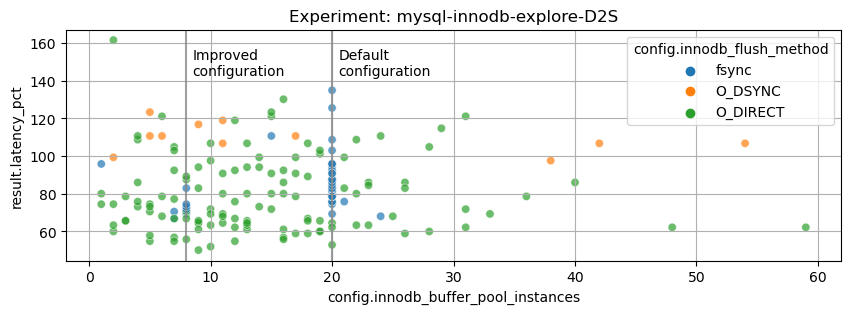

In [9]:
plt.rcParams["figure.figsize"] = (10, 3)

sns.scatterplot(data=df, x=METRIC, y=SCORE, hue=CATEGORY, marker='o', alpha=0.7)

plt.axvline(x=8, color="#888888", alpha=0.8)
plt.text(8.5, 143, "Improved\nconfiguration", horizontalalignment='left', size='medium', color='black')

plt.axvline(x=20, color="#888888", alpha=0.8)
plt.text(20.5, 143, "Default\nconfiguration", horizontalalignment='left', size='medium', color='black')

plt.title("Experiment: " + exp.exp_id)
plt.grid()
plt.show()

In this experiment, we allowed our `mlos_bench` optimizer to explore the configuration space and suggest new benchmark-worthy MySQL configurations. After conducting a number of trials, we picked the best-performing configuration and ran some more trials, comparing this new configuration with our baseline.

### 6. Look at some other experiment

After running a number of experiments and trials, we came up with a shortlist of promising MySQL configurations for more rigorous benchmarking and analysis. In this experiment, we run a large number of additional trials to compare two such configurations. Having many data samples, we can not only analyze the average performance of each configuration, but also look at the variance of the data and assess how robust each configuration is with respect to the fluctuations in the cloud performance.

In [10]:
exp_bench = storage.experiments["mysql-innodb-bseries-v346-vmcontrol"]
df_bench = exp_bench.results

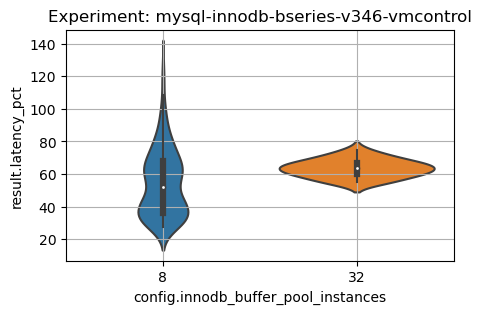

In [11]:
plt.rcParams["figure.figsize"] = (5, 3)

sns.violinplot(data=df_bench, x=METRIC, y=SCORE)

plt.title("Experiment: " + exp_bench.exp_id)
plt.grid()
plt.show()

Here we see that the first configuration (which is actually our winner from the previous experiment) indeed has somewhat better latency on average. However, our other configuration is noticeably more robust and may be a better candidate for a new default MySQL setup on Azure.

----------------------

### 7. Extra: access the data of an individual trial

Sometimes we need to take a closer look at the data from the individual trial. The `ExperimentData.trials` property returns a Python `dict` of trial data records indexed by an integer trial ID.

In [12]:
trial = storage.experiments["mysql-innodb-buf"].trials[16]
trial

mysql-innodb-buf:16 config:705 SUCCEEDED

Each such `TrialData` object allows us to access the configuration of a particular trial as a Pandas DataFrame:

In [13]:
trial.config

,parameter,value
0,innodb_buffer_pool_dump_pct,74
1,innodb_buffer_pool_instances,16
2,innodb_flush_method,O_DIRECT
3,innodb_log_buffer_size,663
4,innodb_old_blocks_pct,92
5,join_buffer_size,280313
6,sort_buffer_size,31080


Some trials can also have an addition key/value pairs of metadata associated with them. Here, for example, we see what optimizer was used to suggest this trial's configuration, and what the optimization target was. Again, the result is a Pandas DataFrame.

In [14]:
trial.metadata

,parameter,value
0,opt_direction,min
1,opt_target,score
2,optimizer,MlosCoreOptimizer:FlamlOptimizer


Similarly, we can retrieve a DataFrame with the benchmark metrics for the trial. Note that even though we optimize for the `score` metric (which is a copy of `latency_pct`), we also collect other metrics with each trial. This data can be reused later in other experiments with different optimziation targets. 

In [15]:
trial.results

,metric,value
0,errors,0.0
1,events,1731.702333
2,latency_pct,55.824272
3,other,35.176485
4,percentile,95.0
5,reads,1234.730116
6,reconnects,0.0
7,score,55.824272
8,threads,0.0
9,time,600.029641


Our framework can also collect some sideband telemetry data during the trial. Unlike the benchmark metrics used for the optimziation, the telemetry metrics can have multiple data points for each metric ID. The resulting DataFrame has three columns for the timestamp, metric ID, and metric value, respectively.

In [16]:
trial.telemetry

,ts,metric,value
0,2023-09-25 19:30:24,errors,0.0
1,2023-09-25 19:30:24,events,1770.030204
2,2023-09-25 19:30:24,latency_pct,50.107444
3,2023-09-25 19:30:24,other,36.048579
4,2023-09-25 19:30:24,percentile,95.0
...,...,...,...
115,2023-09-25 19:39:24,score,54.828067
116,2023-09-25 19:39:24,threads,30.0
117,2023-09-25 19:39:24,time,600.000436
118,2023-09-25 19:39:24,total,1728.884971


In this experiment, our telemetry has the same metrics as the final benchmark, but taken every 60 seconds over the course of the trial.

----------------------------------

### 8. Outro

If you feel curious, please go ahead and explore the MySQL data in the cells below.

After that, please open other notebooks in this repository and look at the SQLite optimization results:

* [**mlos_demo_sqlite.ipynb**](mlos_demo_sqlite.ipynb) - Use this notebook to analyze the data you've collected during this workshop.
* [**mlos_demo_sqlite_teachers.ipynb**](mlos_demo_sqlite_teachers.ipynb) - Teacher's copy, don't peek! :-) Here we analyze the data from 100 trials of SQLite optimization we ran in this codespace before the class. The results you get in the workshop should look similar.